In [12]:
import numpy as np
import pandas as pd
from numpy.random import multivariate_normal as mvnorm
from numpy.linalg import norm

import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
%matplotlib inline

import pdb

seed = 0
np.random.seed(seed)

### Import and generate data

In [38]:
# Import data
data = pd.read_pickle("~/Downloads/integrated_draws_20_5_4.pkl")
n_draws, n_time, dim_X, dim_fac = data['beta'].shape
beta = data['beta']
X_sd = data['x_sd']

# Generate X
m_fac = np.zeros((dim_fac))
s_fac = np.diag(np.ones((dim_fac)))
fac = np.expand_dims(mvnorm(m_fac, s_fac, (n_draws, n_time)), -1)

X = np.matmul(beta, fac).squeeze()

m_eps = np.zeros((dim_X))
for i in range(n_draws):
    eps = mvnorm(m_eps, np.diag(X_sd[i] ** 2), n_time)
    X[i] += X[i] + eps
    
X = X.transpose((2, 0, 1))
X_cov = np.einsum('ijkl,jmkl->imkl', np.expand_dims(X, 1), np.expand_dims(X, 0))

0.0

### Train

In [3]:
# alpha = [20, 40, 60, 80, 100]
alpha = [100, 200, 300, 400]
beta = [100, 200, 300, 400]
# beta = 10

100 100 done
100 200 done
100 300 done
100 400 done
200 100 done
200 200 done
200 300 done
200 400 done
300 100 done
300 200 done
300 300 done
300 400 done
400 100 done
400 200 done
400 300 done
400 400 done


Text(0.5, 1.0, 'Difference in Losses across $\\alpha, \\beta$s')

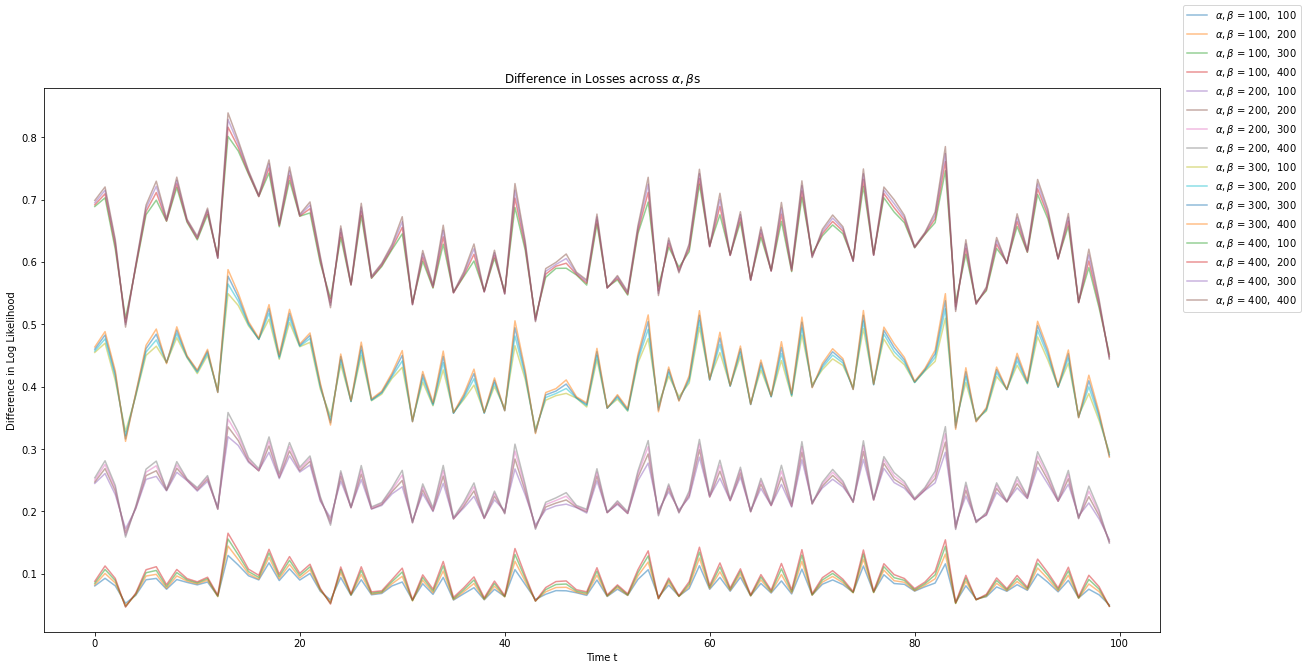

In [4]:
from regain.covariance import TimeGraphicalLasso
fig, ax = plt.subplots(figsize=(20, 10))
fig.patch.set_facecolor('white')
# colors = "bgrcmykw"
# color_index = 0
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20.colors)

fit_pre = {}
emp_pre = {}

for i in alpha:
    for j in beta:
        tgl = TimeGraphicalLasso(alpha=i, beta=j, max_iter=5000, psi="laplacian", gamma=0.9)
        emp_diff, sam_diff, pre = tgl.fit_cov(X_cov).eval_cov_pre(X_cov)    
        emp_pre[i, j] = tgl.emp_inv
        fit_pre[i, j] = pre
    #     pdb.set_trace()
    #     print(emp_diff, np.mean(sam_diff))
        std = np.std(sam_diff, 1)

        ax.plot(range(n_time), emp_diff, alpha=0.5, label=r'$\alpha, \beta$ = {},  {}'.format(i, j))
#         ax.plot(range(n_time), emp_diff, color=colors[color_index], alpha=0.5, label=r'$\alpha, \beta$ = {},  {}'.format(i, j))
#         ax.fill_between(range(n_time), emp_diff, emp_diff - std, color=colors[color_index], alpha=0.2)
#         ax.fill_between(range(n_time), emp_diff, emp_diff + std, color=colors[color_index], alpha=0.2)
#         color_index += 1
        print("{} {} done".format(i, j))

fig.legend()
ax.set_ylabel('Difference in Log Likelihood')
ax.set_xlabel('Time t')
ax.set_title(r'Difference in Losses across $\alpha, \beta$s')  

Text(0.5, 1.0, 'Difference in Sparsity across $\\alpha, \\beta$s')

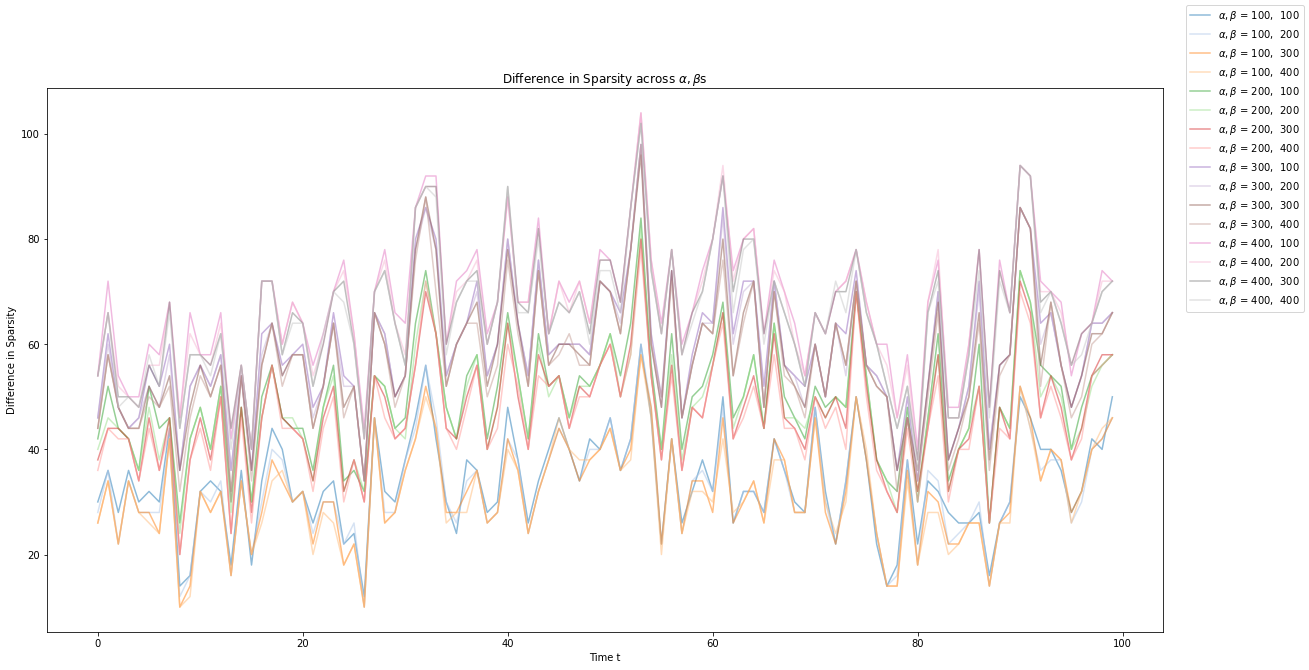

In [11]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.patch.set_facecolor('white')
# colors = "bgrcmykw"
# color_index = 0
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20.colors)

for i in alpha:
    for j in beta:
        ax.plot(range(n_time), [sum(sum(emp_pre[(i, j)][k] > 0)) - sum(sum(fit_pre[(i, j)][k] > 0)) for k in range(n_time)], alpha=0.5, label=r'$\alpha, \beta$ = {},  {}'.format(i, j))

fig.legend()
ax.set_ylabel('Difference in Sparsity')nor
ax.set_xlabel('Time t')
ax.set_title(r'Difference in Sparsity across $\alpha, \beta$s')  

Text(0.5, 1.0, 'Difference in Frobenius Norm across $\\alpha, \\beta$s')

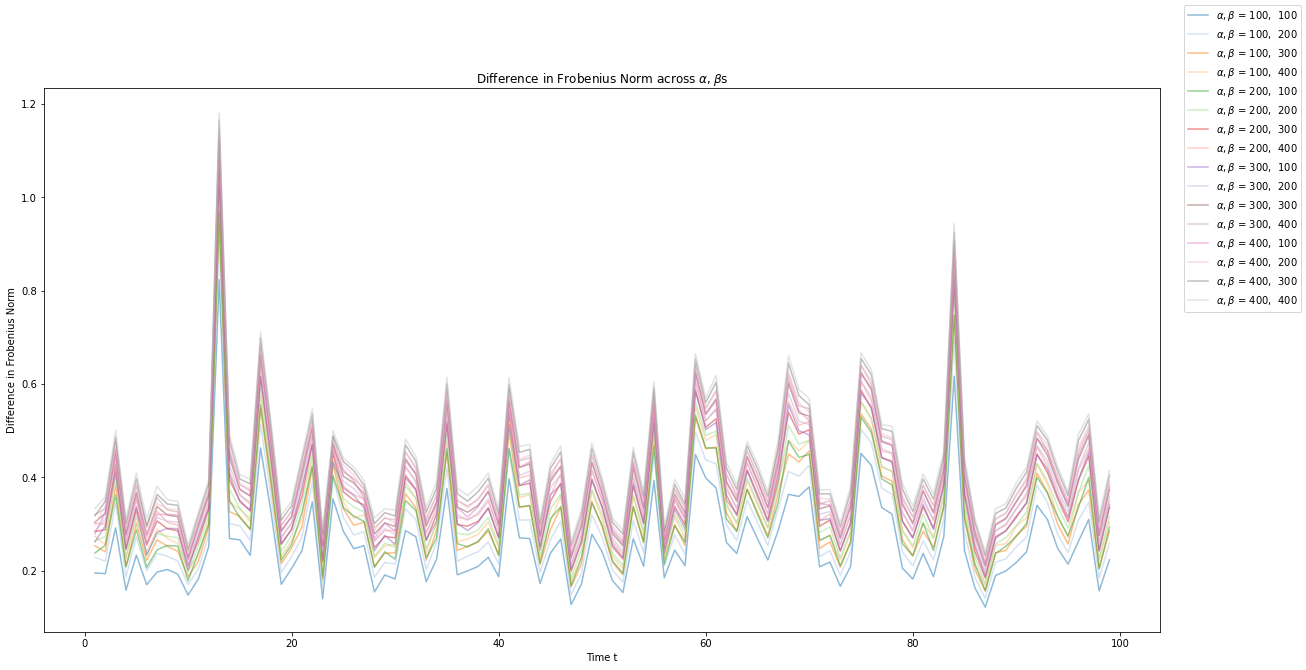

In [36]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.patch.set_facecolor('white')
# colors = "bgrcmykw"
# color_index = 0
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20.colors)

for i in alpha:
    for j in beta:
        diff_fit = [norm(fit_pre[(i, j)][k] - fit_pre[(i, j)][k-1], 'fro') for k in range(1, 100)]
        diff_emp = [norm(emp_pre[(i, j)][k] - emp_pre[(i, j)][k-1], 'fro') for k in range(1, 100)]
        ax.plot(range(1, n_time), np.array(diff_emp) - np.array(diff_fit), alpha=0.5, label=r'$\alpha, \beta$ = {},  {}'.format(i, j))

fig.legend()
ax.set_ylabel('Difference in Frobenius Norm')
ax.set_xlabel('Time t')
ax.set_title(r'Difference in Frobenius Norm across $\alpha, \beta$s')